<a href="https://colab.research.google.com/github/sherlockieee/cs166/blob/main/CS166%08_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import heapq
import numpy as np

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs


    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp


    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    

    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    

    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    

    def next_event_time(self):
        # Return the time of the next event. The `now` attribute of this class
        # contain the time of the last event that was run.
        return self.priority_queue[0].timestamp


    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp

        # print(f'At{event.timestamp: .2f}s: {event.function.__name__}')
        event.run(self)
        

    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    
    def print_events(self):
        # Print out diagnostic information about the events in the schedule.
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [2]:
import scipy.stats as sts 
from collections import deque

class Queue:
    '''
    Tracks the number of people in the queue and store their waiting time.
    Schedule passengers' arrival to the queue and remove passengers from queue
    when the bus comes.

    Parameters
    ----------
    id : int
        The stop ID of the queue
    arrival_distribution: scipy.stats distribution
        Passenger arrival distribution

    Attributes
    ----------
    stop_id : int
        The stop ID of the queue
    arrival_distribution: scipy.stats distribution
        Passenger arrival distribution
    passengers: deque[Passenger]
        A queue of passenger objects currently at the stop
    waiting_time_storage: list[float]
        A list of passengers waiting time, updated when passengers are removed from queue
    max_queue_length: int
        Maximum queue length at any point in time
    '''

    def __init__(self, id: int, arrival_distribution):
        self.stop_id = id
        self.arrival_distribution = arrival_distribution
        self.passengers = deque()
        self.waiting_time_storage = []
        self.max_queue_length = 0


    def __repr__(self):
        return f"Stop {self.stop_id}: {len(self.passengers)} passengers"


    def passenger_arrival(self, schedule: Schedule, current_time: float):
        '''
        Schedule passenger arrival and update the queue object accordingly

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation
        current_time: float
            The current time that passenger arrives

        Returns
        ----------
        None
        '''
        #create a new person and add them to the queue
        passenger = Passenger(starting_time = current_time, embark_stop = self.stop_id)
        self.passengers.append(passenger)
        #schedule the arrival of the next person
        next_arrival = self.arrival_distribution.rvs()
        #update max queue length
        self.max_queue_length = max(self.max_queue_length, len(self.passengers))
        #schedule another arrival
        schedule.add_event_after(next_arrival, self.passenger_arrival, current_time + next_arrival)


    def remove_passenger(self, current_time: float):
        '''
        Remove a passenger and add their waiting time to storage
        Note that there's no schedule because it's handled by the Bus object function

        Parameters
        ----------
        current_time: float
            The current time that passenger arrives

        Returns
        ----------
        None
        '''
        passenger = self.passengers.popleft()
        passenger.set_embarking_time(current_time)
        self.waiting_time_storage.append(passenger.get_waiting_time())
        return passenger


    def run(self, schedule):
        '''
        Start running the system

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None
        '''
        next_arrival = self.arrival_distribution.rvs()
        schedule.add_event_after(next_arrival, self.passenger_arrival, schedule.now + next_arrival)




class QueueSystem:
    '''
    Contains all the queues in the system.

    Parameters
    ----------
    arrival_distribution: scipy.stats distribution
        Passenger arrival distribution for all queues
    no_of_stops: int
        Number of queues needed (1 per stop)

    Attributes
    ----------
    queues: list[Queue]
        A list of all the queues, one for each stop
    '''

    def __init__(self, arrival_distribution, no_of_stops):
        self.queues = [Queue(id, arrival_distribution) for id in range(no_of_stops)]


    def __repr__(self):
        string = ''
        for queue in self.queues:
            string += str(queue) + '\n'
        return string


    def get_average_waiting_time(self):
        '''
        Get average waiting time across all queues.

        Parameters
        ----------
        None

        Returns
        ----------
        float
            Average waiting time across all queues
        '''
        total_waiting_times = 0
        n = 0
        for queue in self.queues:
            total_waiting_times += np.sum(queue.waiting_time_storage)
            n += len(queue.waiting_time_storage)
        return total_waiting_times/n


    def get_max_queue_length(self):
        '''
        Get maximum queue length across all queues.

        Parameters
        ----------
        None

        Returns
        ----------
        float
            maximum queue length across all queues
        '''
        max_length = 0
        for queue in self.queues:
            max_length = max(queue.max_queue_length, max_length)
        return max_length


    def get_max_waiting_time(self):
        '''
        Get maximum waiting time across all queues.

        Parameters
        ----------
        None

        Returns
        ----------
        float
            Maximum waiting time across all queues
        '''
        max_waiting_time = 0
        for queue in self.queues:
            if not queue.waiting_time_storage:
                continue
            max_waiting_time = max(max_waiting_time, max(queue.waiting_time_storage))
        return max_waiting_time


    def run(self, schedule: Schedule):
        '''
        Start running the system

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None
        '''
        for queue in self.queues:
            queue.run(schedule)
            
        


In [3]:

class Bus:
    '''
    Embark passengers, travel to next stop and disembark passengers.

    Parameters
    ----------
    id: int
        The id of the bus
    current_stop: int
        The stop id that the bus is at
    queue_system: QueueSystem
        All the queues at all the stops the bus needs to go through
    max_capacity: int
        Maximum capacity of the bus
    travel_distribution: sts.stats distribution
        The travelling distribution of the bus
    embark_distribution: sts.stats distribution
        Embarking distribution for 1 passenger
    disembark_distribution: sts.stats distribution
        Disembarking distribution for 1 passenger
    

    Attributes
    ----------
    id: int
        The id of the bus
    current_stop: int
        The stop id that the bus is at
    queue_system: QueueSystem
        All the queues at all the stops the bus needs to go through
    no_of_stops: int
        Number of stops in the system
    travel_distribution: sts.stats distribution
        The travelling distribution of the bus
    embark_distribution: sts.stats distribution
        Embarking distribution for 1 passenger
    disembark_distribution: sts.stats distribution
        Disembarking distribution for 1 passenger
    passenger_in_bus: int
        Number of passengers in the bus
    max_capacity: int
        Maximum capacity of the bus
    stops_to_passengers_disembark_dict: dict[int, deque]
        A dictionary that maps each stop in the queues to a queue of passengers
        who want to get off at that stop
    passengers_served: int
        Total number of all passengers that the bus has served
    
    '''
    def __init__(self, id: int, current_stop: int, queue_system: QueueSystem,
                 max_capacity: int, travel_distribution, disembark_distribution, 
                 embark_distribution):
        self.id = id
        self.current_stop = current_stop
        self.queue_system = queue_system
        self.no_of_stops = len(self.queue_system.queues)
        self.travel_distribution = travel_distribution
        self.disembark_distribution = disembark_distribution
        self.embark_distribution = embark_distribution
        self.passengers_in_bus = 0
        self.max_capacity = max_capacity
        self.stop_to_passengers_disembark_dict = {i: deque() for i in range(self.no_of_stops)}
        self.passengers_served = 0


    def __repr__(self):
        return f"Bus id {self.id} currently at stop no. {self.current_stop} with {self.passengers_in_bus} passengers"


    def embark_passengers(self, schedule):
        '''
        Embark passengers on the current stop

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None
        '''
        current_queue = self.queue_system.queues[self.current_stop]
        current_time = schedule.now

        # find number of people who can embark
        n = min(self.max_capacity - self.passengers_in_bus, len(current_queue.passengers))
        #remove these passengers from queue and add them to the bus
        for i in range(n):
            current_time += self.embark_distribution.rvs()
            passenger = current_queue.remove_passenger(current_time)
            passenger.set_bus(self)
            disembark_stop = passenger.get_disembark_stop()
            self.stop_to_passengers_disembark_dict[disembark_stop].append(passenger)
        self.passengers_in_bus += n
        self.passengers_served += n
        #immediately after, start traveling to next stop
        schedule.add_event_after(current_time - schedule.now, self.travel_to_next_stop)


    def travel_to_next_stop(self, schedule):
        '''
        Travel to the next stop

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None
        '''
        self.current_stop = (self.current_stop + 1) % self.no_of_stops
        #after a certain traveling time, start disembarking customer
        schedule.add_event_after(self.travel_distribution.rvs(), self.disembark_passengers)


    def disembark_passengers(self, schedule):
        '''
        Disembark passengers at the current stop

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None
        '''
        current_time = schedule.now

        #remove all people who want to disembark at this stop
        n = len(self.stop_to_passengers_disembark_dict[self.current_stop])
        while self.stop_to_passengers_disembark_dict[self.current_stop]:
            current_time += self.disembark_distribution.rvs()
            passenger = self.stop_to_passengers_disembark_dict[self.current_stop].popleft()
            passenger.set_disembarking_time(current_time)
        self.passengers_in_bus -= n
        
        #immediately after, start embarking customers
        schedule.add_event_after(current_time - schedule.now, self.embark_passengers)


    def run(self, schedule):
        '''
        Start running the system

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None
        '''
        schedule.add_event_after(0, self.embark_passengers)



class BusSystem:
    '''
    A system containing all the buses.

    Parameters
    ----------
    queue_system: QueueSystem
        All the queues at all the stops the bus needs to go through
    number_of_buses: int
        Number of buses in all bus systems
    max_capacity: int
        Maximum capacity of the bus
    travel_distribution: sts.stats distribution
        The travelling distribution of the bus
    embark_distribution: sts.stats distribution
        Embarking distribution for 1 passenger
    disembark_distribution: sts.stats distribution
        Disembarking distribution for 1 passenger
    

    Attributes
    ----------
    buses: list[Bus]
        A list of all buses in the bus system
    '''
    def __init__(self, queue_system: QueueSystem, number_of_buses: int, 
                 travel_distribution, disembark_distribution, embark_distribution,  
                 max_capacity: int):
        self.buses = []
        increment = len(queue_system.queues) // number_of_buses
        for i in range(number_of_buses):
            self.buses.append(Bus(id = i, current_stop = increment * i, 
                                  travel_distribution = travel_distribution, 
                                  disembark_distribution = disembark_distribution, 
                                  embark_distribution = embark_distribution,  
                                  max_capacity = max_capacity, 
                                  queue_system = queue_system))


    def __repr__(self):
        string = f'\n------------------\nBus system with {len(self.buses)} buses\n'
        for bus in self.buses:
            string += str(bus) + '\n'
        string += '------------------'
        return string

    def get_passengers_served(self):
        total_passengers = 0
        for bus in self.buses:
            total_passengers += bus.passengers_served
        return total_passengers

    def run(self, schedule):
        '''
        Start running the system

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None
        '''
        for bus in self.buses:
            bus.run(schedule)

    


In [4]:

class Passenger:
    '''
    Contain information related to passenger

    Parameters
    ----------
    embark_stop: int
        The stop that the passenger starts the journey
    starting_time: float
        The time the passenger arrives to the stop
    

    Attributes
    ----------
    starting_time: float
        The time the passenger arrives to the stop
    embark_stop: int
        The stop that the passenger gets on the bus
    disembark_stop: int/ None
        The stop that the passenger gets off the bus
    enbarking_time: float/ None
        The time the passenger gets on the bus
    disembarking_time: float/ None
        The time the passenger gets off the bus
    bus: Bus/ None
        The bus that the passenger travels on
    '''
    def __init__(self, embark_stop: int, starting_time: float):
        self.starting_time: float = starting_time
        self.embark_stop: int = embark_stop
        self.disembark_stop: int = None
        self.embarking_time: float = None
        self.disembarking_time: float = None
        self.bus: Bus = None


    def __repr__(self):
        return f'Passenger from stop {self.embark_stop}, starting time {self.starting_time}'


    def set_bus(self, bus: Bus):
        '''
        Set the bus where passenger is travelling on
        '''
        self.bus = bus


    def get_disembark_stop(self):
        '''
        Get the stop where passenger will get off the bus
        '''
        if not self.disembark_stop:
            no_of_stops = np.random.randint(1, self.bus.no_of_stops // 2 + 1)
            self.disembark_stop = (self.embark_stop + no_of_stops) % self.bus.no_of_stops
        return self.disembark_stop


    def set_embarking_time(self, time: float):
        '''
        Set the time where passenger gets on the bus
        '''
        if time < self.starting_time:
            raise ValueError("Embarking time larger than starting time")
        self.embarking_time = time


    def set_disembarking_time(self, time: float):
        '''
        Set the time where passenger gets off the bus
        '''
        if time < self.embarking_time:
            raise ValueError("Disembarking time larger than embarking time")
        self.disembarking_time = time


    def get_waiting_time(self):
        '''
        Get the passenger's waiting time
        '''
        if self.embarking_time is None:
            raise ValueError("Embarking time is empty")
        return self.embarking_time - self.starting_time


    def get_traveling_time(self):
        '''
        Get the passenger's waiting time
        '''
        if self.disembarking_time is None or self.embarking_time is None:
            raise ValueError
        return self.disembarking_time - self.embarking_time
        


In [5]:
arrival_distribution = sts.expon(scale=1)
travel_distribution = sts.truncnorm(a=0, b=np.inf, loc=2, scale=0.5)
disembark_distribution = sts.truncnorm(a=0, b=np.inf, loc=0.03, scale=0.01)
embark_distribution = sts.truncnorm(a=0, b=np.inf, loc=0.05, scale=0.01)
no_of_stops = 15
max_capacity = 130

def run_simulation(no_of_buses: int, run_until: float, 
                   arrival_distribution=arrival_distribution,
                   travel_distribution=travel_distribution, 
                   disembark_distribution=disembark_distribution,
                   no_of_stops=no_of_stops, max_capacity=max_capacity):
    schedule = Schedule()
    queue_system = QueueSystem(arrival_distribution=arrival_distribution, 
                               no_of_stops=no_of_stops)
    queue_system.run(schedule)
    bus_system = BusSystem(queue_system, no_of_buses, travel_distribution, 
                           disembark_distribution, embark_distribution, 
                           max_capacity)
    bus_system.run(schedule)

    #run schedule until our marked end time
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    
    
    return queue_system, bus_system
    
run_simulation(5, 60)

(Stop 0: 2 passengers
 Stop 1: 3 passengers
 Stop 2: 3 passengers
 Stop 3: 11 passengers
 Stop 4: 13 passengers
 Stop 5: 6 passengers
 Stop 6: 4 passengers
 Stop 7: 11 passengers
 Stop 8: 13 passengers
 Stop 9: 4 passengers
 Stop 10: 0 passengers
 Stop 11: 14 passengers
 Stop 12: 11 passengers
 Stop 13: 7 passengers
 Stop 14: 4 passengers, 
 ------------------
 Bus system with 5 buses
 Bus id 0 currently at stop no. 3 with 54 passengers
 Bus id 1 currently at stop no. 7 with 48 passengers
 Bus id 2 currently at stop no. 11 with 48 passengers
 Bus id 3 currently at stop no. 1 with 12 passengers
 Bus id 4 currently at stop no. 1 with 24 passengers
 ------------------)

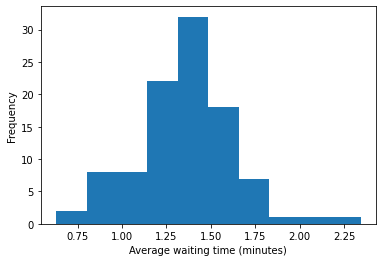

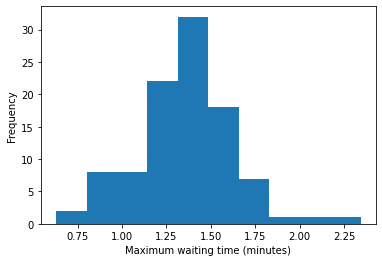

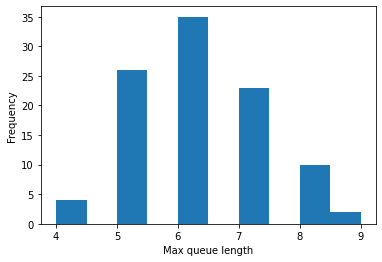

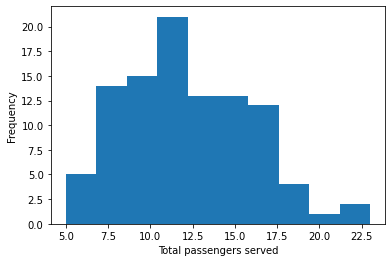

(1.3562057553716154,
 0.051975889537515085,
 2.3420239695957146,
 0.0595828594191663,
 6.15,
 0.21913670539797447,
 12.14,
 0.75042849915212)

In [6]:
#run simulation 100 times
import matplotlib.pyplot as plt
import numpy as np

def get_experiment_results(no_of_buses, alpha = 0.95, run_until = 100, reps = 100, display = True):
    results = []
    max_wt_results = []
    q_results = []
    bus_results = []
    for i in range(reps):
        queue_system, bus_system = run_simulation(no_of_buses, run_until)
        results.append(queue_system.get_average_waiting_time())
        max_wt_results.append(queue_system.get_max_waiting_time())
        q_results.append(queue_system.get_max_queue_length())
        bus_results.append(bus_system.get_passengers_served())

    #average waiting time
    wt_mean = np.mean(results)
    lower_bound, upper_bound = sts.t.interval(alpha=alpha, 
                                             df=len(results)-1, 
                                             loc=np.mean(results),
                                             scale=sts.sem(results)) 
    wt_errors = upper_bound - wt_mean

    #max waiting time
    max_wt_mean = np.mean(max_wt_results)
    max_wt_lower_bound, max_wt_upper_bound = sts.t.interval(alpha=alpha, 
                                             df=len(max_wt_results)-1, 
                                             loc=np.mean(max_wt_results),
                                             scale=sts.sem(max_wt_results)) 
    max_wt_errors = max_wt_upper_bound - max_wt_mean
     
    #max queue length
    q_mean = np.mean(q_results)
    q_lower_bound, q_upper_bound = sts.t.interval(alpha=alpha, 
                                             df=len(q_results)-1, 
                                             loc=np.mean(q_results),
                                             scale=sts.sem(q_results)) 
    q_errors = q_upper_bound - q_mean

    #total passengers served
    bus_mean = np.mean(bus_results)
    bus_lower_bound, bus_upper_bound = sts.t.interval(alpha=alpha, 
                                             df=len(bus_results)-1, 
                                             loc=np.mean(bus_results),
                                             scale=sts.sem(bus_results)) 
    bus_errors = bus_upper_bound - bus_mean

    if display:
        plt.hist(results)
        plt.xlabel('Average waiting time (minutes)')
        plt.ylabel('Frequency')
        plt.show()

        plt.hist(results)
        plt.xlabel('Maximum waiting time (minutes)')
        plt.ylabel('Frequency')
        plt.show()

        plt.hist(q_results)
        plt.xlabel('Max queue length')
        plt.ylabel('Frequency')
        plt.show()

        plt.hist(bus_results)
        plt.xlabel('Total passengers served')
        plt.ylabel('Frequency')
        plt.show()

    return wt_mean, wt_errors, max_wt_mean, max_wt_errors, q_mean, q_errors, bus_mean, bus_errors

get_experiment_results(5, run_until=3)

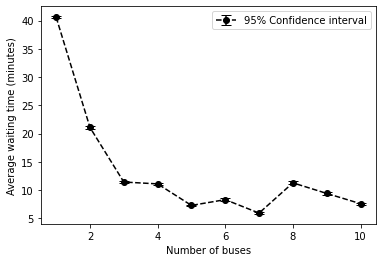

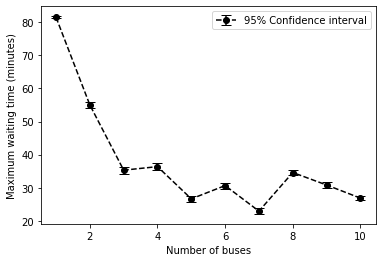

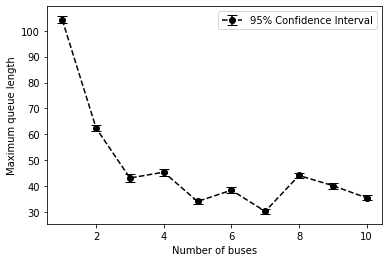

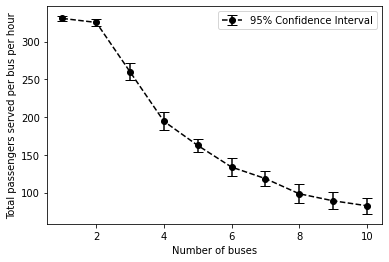

In [9]:
#warning: This usually takes about 8 minutes to run
x_axis = range(1, 11)

exp_wt_mean = []
exp_max_wt_mean = []
exp_max_q_mean = []


wt_errors = []
max_wt_errors = []
q_errors = []

exp_bus_mean = []
bus_errors = []

for no_of_buses in x_axis:
    wt_mean, wt_error, max_wt_mean, max_wt_error, q_mean, q_error, bus_mean, bus_error = get_experiment_results(no_of_buses, 
                                    reps = 100, run_until = 120, display=False)
    exp_wt_mean.append(wt_mean)
    wt_errors.append(wt_error)

    exp_max_wt_mean.append(max_wt_mean)
    max_wt_errors.append(max_wt_error)

    exp_max_q_mean.append(q_mean)
    q_errors.append(q_error)

    exp_bus_mean.append(bus_mean/ no_of_buses/ 2)
    bus_errors.append(bus_error)


plt.errorbar(x_axis, exp_wt_mean, yerr=wt_errors, marker='o', capsize=5, color='black', linestyle='--', label='95% Confidence interval')
plt.xlabel("Number of buses")
plt.ylabel("Average waiting time (minutes)")
plt.legend()
plt.show()

plt.errorbar(x_axis, exp_max_wt_mean, yerr=max_wt_errors, marker='o', capsize=5, color='black', linestyle='--', label='95% Confidence interval')
plt.xlabel("Number of buses")
plt.ylabel("Maximum waiting time (minutes)")
plt.legend()
plt.show()


plt.errorbar(x_axis, exp_max_q_mean, yerr=q_errors, marker='o', capsize=5, color='black', linestyle='--', label='95% Confidence Interval')
plt.xlabel("Number of buses")
plt.ylabel("Maximum queue length")
plt.legend()
plt.show()

plt.errorbar(x_axis, exp_bus_mean, yerr=bus_errors, marker='o', capsize=5, color='black', linestyle='--', label='95% Confidence Interval')
plt.xlabel("Number of buses")
plt.ylabel("Total passengers served per bus per hour")
plt.legend()
plt.show()


In [13]:
for bus_no in [3, 5, 7]:
    print(f"\nNumber of bus: {bus_no}")
    print(f"Average waiting time: {exp_wt_mean[bus_no - 1]:.2f} minutes, standard deviation: {wt_errors[bus_no - 1]:.2f} minutes")
    print(f"Max waiting time: {exp_max_wt_mean[bus_no - 1]:.2f} minutes, standard deviation: {max_wt_errors[bus_no - 1]:.2f} minutes")
    print(f"Max queue length: {exp_max_q_mean[bus_no - 1]:.2f} people, standard deviation: {q_errors[bus_no - 1]:.2f} people")
    print(f"Number passengers served/bus/hour: {exp_bus_mean[bus_no - 1]:.2f} people, standard deviation: {bus_errors[bus_no - 1]:.2f} people")


Number of bus: 3
Average waiting time: 11.43 minutes, standard deviation: 0.15 minutes
Max waiting time: 35.30 minutes, standard deviation: 1.07 minutes
Max queue length: 43.18 people, standard deviation: 1.43 people
Number passengers served/bus/hour: 259.83 people, standard deviation: 11.43 people

Number of bus: 5
Average waiting time: 7.29 minutes, standard deviation: 0.16 minutes
Max waiting time: 26.63 minutes, standard deviation: 0.82 minutes
Max queue length: 34.12 people, standard deviation: 1.04 people
Number passengers served/bus/hour: 162.41 people, standard deviation: 8.85 people

Number of bus: 7
Average waiting time: 5.94 minutes, standard deviation: 0.15 minutes
Max waiting time: 22.92 minutes, standard deviation: 0.84 minutes
Max queue length: 30.32 people, standard deviation: 0.99 people
Number passengers served/bus/hour: 118.51 people, standard deviation: 9.89 people
